### Checking out the data for obvious outliers, special features, feature scales etc.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
data = pd.read_csv("../data/train.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

The ames housing data has therefore 3 continuous scalar features, 35 integer features and 43 (!) categorical features. This is mainly a categorical feature based dataset. Interesting.

In [3]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Total of 81 Columns (ie. Features). Multiple continuous & integer scalar features and a lot of categorical features. There's more categorical features than actual numerical features. Let us further investigate categorical features.

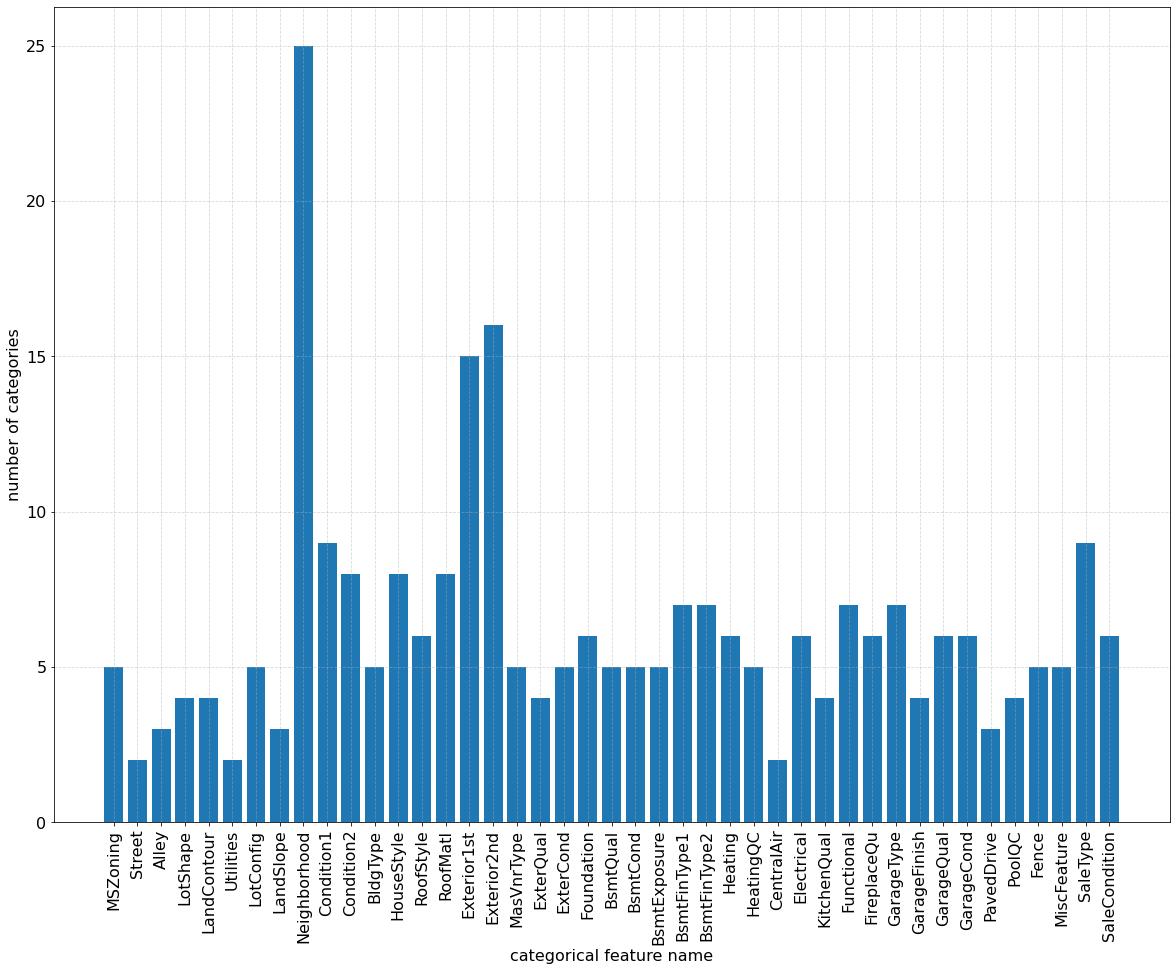

In [4]:
df_sel = data.select_dtypes(include="object")
columns = df_sel.columns.tolist()
num_categories = []
fig, ax = plt.subplots(figsize=(20,15))
for column in df_sel:
    num_categories.append(len(df_sel[column].unique()))
x = np.arange(len(columns))
ax.bar(x, num_categories)
plt.xticks(x, columns, rotation="vertical", fontsize=20)
plt.grid(alpha=0.5, linestyle="--")
plt.ylabel("number of categories", fontsize=16)
plt.xlabel("categorical feature name", fontsize=16)
ax.tick_params(labelsize=16)
plt.show()

Encode the categorical variables.

In [7]:
# get scalar variables
df_enc = data.select_dtypes(exclude="object")
df_enc = pd.concat([df_enc, pd.get_dummies(df_sel)], axis=1)
y_df = df_enc["SalePrice"]
X_df = df_enc.drop(columns=["SalePrice"])

Visualize all Sales Prices in dataset as a histogram.

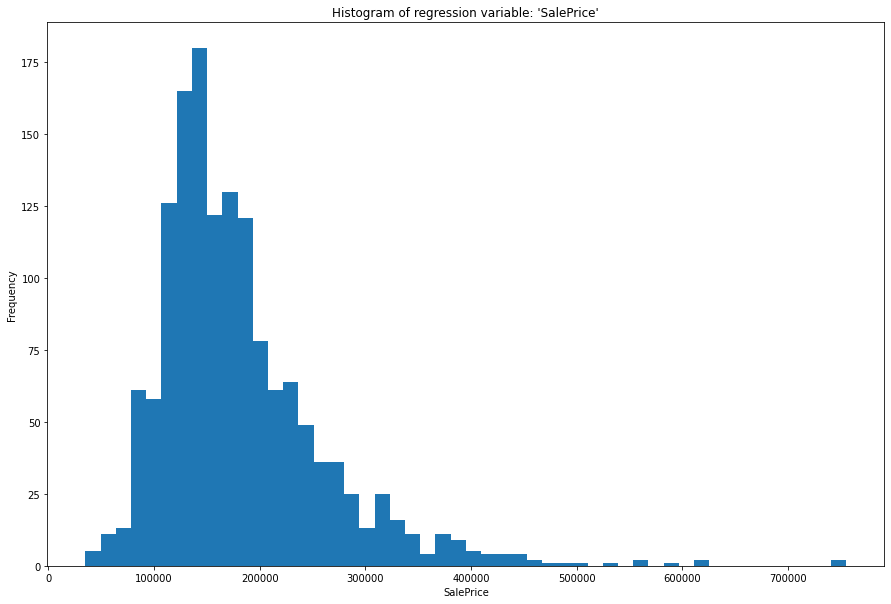

In [8]:
fig, ax = plt.subplots(figsize=(15, 10))
y_df.plot(kind="hist", ax=ax, bins=50)
ax.set_title("Histogram of regression variable: 'SalePrice'")
ax.set_xlabel("SalePrice")
plt.show()

Get rid of NaN values.

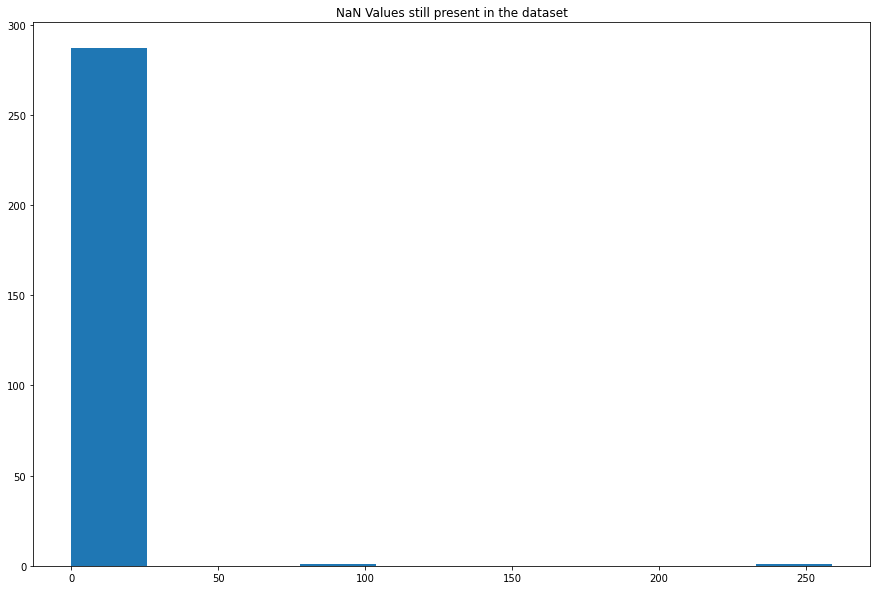

In [77]:
plt.figure(figsize=(15,10))
plt.title("NaN Values still present in the dataset")
plt.hist(X_df.isnull().sum().tolist())
plt.show()

If we plot the actual data columns that have NaN values, we see that these are integer type, ie. leftover from the split between categorical and scalar values (all the categorical NaN values we saw earlier were converted into nice categorical dummy variables)

In [76]:
data[X_df.columns[np.where(X_df.isnull().sum() != 0)[0]]]

,LotFrontage,MasVnrArea,GarageYrBlt
0,65.0,196.0,2003.0
1,80.0,0.0,1976.0
2,68.0,162.0,2001.0
3,60.0,0.0,1998.0
4,84.0,350.0,2000.0
...,...,...,...
1455,62.0,0.0,1999.0
1456,85.0,119.0,1978.0
1457,66.0,0.0,1941.0
1458,68.0,0.0,1950.0


Median impute these values with the pandas fillna functionality.

In [84]:
bad_columns = X_df.columns[np.where(X_df.isnull().sum() != 0)[0]]
medians = data[bad_columns].median()
imputation_values = {column: imputation_val for column, imputation_val in zip(bad_columns, medians)}

X_df.fillna(value=imputation_values, inplace=True)

Standardize scalar features before applying any dimensionality reduction.

In [99]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

non_cat_columns = data.select_dtypes(exclude="object").drop(columns="SalePrice").columns
print("X data before standardization of scalar features")
print(X_df[non_cat_columns].head())
print("X data after standardization of scalar features")
X_df[non_cat_columns] = scaler.fit_transform(X_df[non_cat_columns])
print(X_df[non_cat_columns].head())

X data before standardization of scalar features
   Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0   1          60         65.0     8450            7            5       2003   
1   2          20         80.0     9600            6            8       1976   
2   3          60         68.0    11250            7            5       2001   
3   4          70         60.0     9550            7            5       1915   
4   5          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  GarageArea  WoodDeckSF  \
0          2003       196.0         706  ...         548           0   
1          1976         0.0         978  ...         460         298   
2          2002       162.0         486  ...         608           0   
3          1970         0.0         216  ...         642           0   
4          2000       350.0         655  ...         836         192   

   OpenPorchSF  EnclosedPorch  3SsnPo

### Plot 2D PCA projection vs. colorscaled price + Rudimentary Visual Outlier Detection

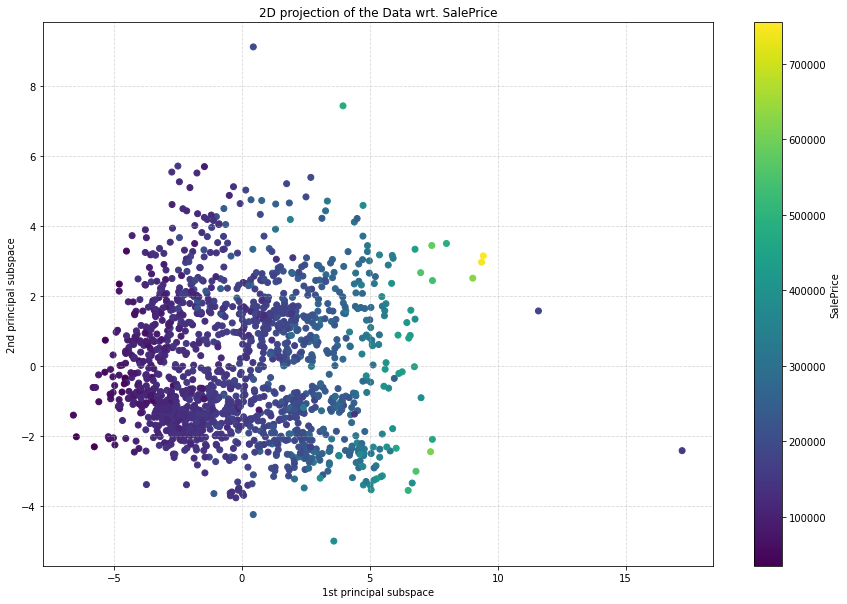

In [108]:
from sklearn.decomposition import PCA


pca = PCA(n_components=2, svd_solver="full")

X_trf_2D = pca.fit_transform(X_df.values)

fig, ax = plt.subplots(figsize=(15,10))
im = ax.scatter(X_trf_2D.T[0], X_trf_2D.T[1], c=y_df.values, cmap="viridis")
plt.grid(alpha=0.5, linestyle="--")
ax.set_title("2D projection of the Data wrt. SalePrice")
fig.colorbar(im, ax=ax, label="SalePrice")
plt.xlabel("1st principal subspace")
plt.ylabel("2nd principal subspace")
plt.show()

There's a nice flow from left to right wrt. the SalePrice variable. We can see some obvious outliers here. In total 4 outlier points that we would have to cut out of the dataset.
Get these datapoints and their index in the training data.

In [11]:
type(X_df)

pandas.core.frame.DataFrame

In [116]:
# choose limits for outliers from visual inspection
xlim = 10
ylim = 6

outlier_indices = []
x_outliers = np.where(X_trf_2D.T[0] >= xlim)[0].tolist()
y_outliers = np.where(X_trf_2D.T[1] >= ylim)[0].tolist()
print("1st principal subspace visual outlier-indices:")
print(x_outliers)
print("2nd principal subspace visual outlier-indices:")
print(y_outliers)
outlier_indices = x_outliers + y_outliers
X_df = X_df.drop(labels=outlier_indices, axis=0)
X_df

1st principal subspace visual outlier-indices:
[523, 1298]
2nd principal subspace visual outlier-indices:
[185, 635]


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,-1.730865,0.073375,-0.220875,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.514104,0.575425,...,0,0,0,1,0,0,0,0,1,0
1,-1.728492,-0.872563,0.460320,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.570750,1.171992,...,0,0,0,1,0,0,0,0,1,0
2,-1.726120,0.073375,-0.084636,0.073480,0.651479,-0.517200,0.984752,0.830215,0.325915,0.092907,...,0,0,0,1,0,0,0,0,1,0
3,-1.723747,0.309859,-0.447940,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.570750,-0.499274,...,0,0,0,1,1,0,0,0,0,0
4,-1.721374,0.073375,0.641972,0.375148,1.374795,-0.517200,0.951632,0.733308,1.366489,0.463568,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1.721374,0.073375,-0.357114,-0.260560,-0.071836,-0.517200,0.918511,0.733308,-0.570750,-0.973018,...,0,0,0,1,0,0,0,0,1,0
1456,1.723747,-0.872563,0.687385,0.266407,-0.071836,0.381743,0.222975,0.151865,0.087911,0.759659,...,0,0,0,1,0,0,0,0,1,0
1457,1.726120,0.309859,-0.175462,-0.147810,0.651479,3.078570,-1.002492,1.024029,-0.570750,-0.369871,...,0,0,0,1,0,0,0,0,1,0
1458,1.728492,-0.872563,-0.084636,-0.080160,-0.795151,0.381743,-0.704406,0.539493,-0.570750,-0.865548,...,0,0,0,1,0,0,0,0,1,0
